# Path setup & import packages

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle

# Read config & basic setup

In [16]:
config_file_path = '{}/configs/movies_ranking_experiment.yaml'.format(root_path)

with open(config_file_path,'r') as conf_file:
    conf = yaml.full_load(conf_file)
    conf['project_root'] = root_path 

data_conf = conf['data_conf']
weak_sup_conf = conf['weak_sup_conf'] # For partial ranking experiments, we should give
l2r_training_conf = conf['l2r_training_conf']
data_conf['project_root'] = root_path

In [17]:
weak_sup_conf

{'checkpoint_path': 'data/processed/movies_example/LFs',
 'inference_rule': 'weighted_kemeny_TDDK',
 'lf_features': ['revenue',
  'gross',
  'runtime',
  'popularity',
  'movie_facebook_likes',
  'cast_total_facebook_likes',
  'num_user_for_reviews',
  'director_facebook_likes',
  'actor_facebook_likes',
  'budget_tmdb'],
 'lf_features_highest_first_flag': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 'num_LFs': 10,
 'p': None,
 'recreate_if_exists': True,
 'seed': 0,
 'synthetic': True,
 'train_method': 'triplet_opt'}

# Dataset sampling

In [4]:
dataset= datasets_factory.create_dataset(data_conf)
dataset.create_samples()

Generate samples...


# Label model learning & inference

In [18]:
if l2r_training_conf['use_weak_labels']:
    Y_tilde, thetas, individual_kt = get_weak_labels(dataset, weak_sup_conf, root_path=root_path)
    r_utils = RankingUtils(data_conf['dimension'])
    kt = r_utils.mean_kt_distance(Y_tilde,dataset.Y)
    print('Label model kt distance: ', kt)
    dataset.set_Y_tilde(Y_tilde)
else:
    kt = None

Weak labels generated and saved in ../../data/processed/movies_example/LFs/synthetic_weak_labels.pkl
Use our weak supervision...train_method: triplet_opt,inference_rule: weighted_kemeny_TDDK
Label model kt distance:  0.3556000000000001


# Train and evaluation - mainly with PtrankingWrapper

In [19]:
ptwrapper = PtrankingWrapper(data_conf=data_conf, weak_sup_conf=weak_sup_conf,
                             l2r_training_conf=l2r_training_conf, result_path=conf['results_path'],
                             wl_kt_distance = kt)
X_train, X_test, Y_train, Y_test = dataset.get_train_test_torch(use_weak_labels=l2r_training_conf['use_weak_labels'])
ptwrapper.set_data(X_train=X_train, X_test=X_test,
                  Y_train=Y_train, Y_test=Y_test)
model = ptwrapper.get_model()

# normal_result = ptwrapper.train_model(model, verbose=1)
TDDK_results = ptwrapper.train_model(model, verbose=1)


use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 205]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 205) (500, 5) (500,)
data_dict {'data_id': 'movies', 'dir_data': 'data/processed/movies/movies_example', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 205, 'has_comment': False, 'label_type': <LABEL_TYPE.Permutation: 2>, 'max_rele_level': None, 'fold_num': 1}
data_dict {'data_id': 'movies', 'dir_data': 'data/processed/movies/movies_example', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size

# Training log visualization

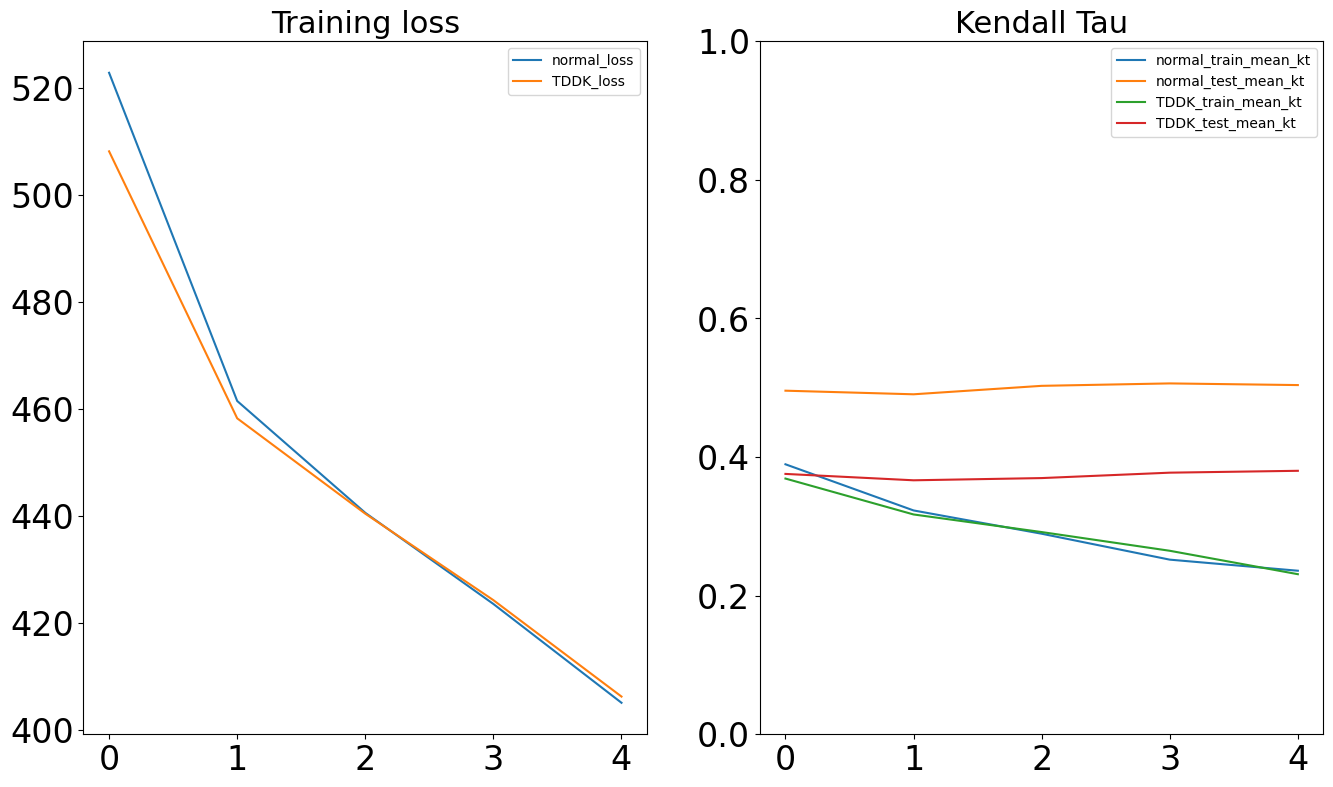

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


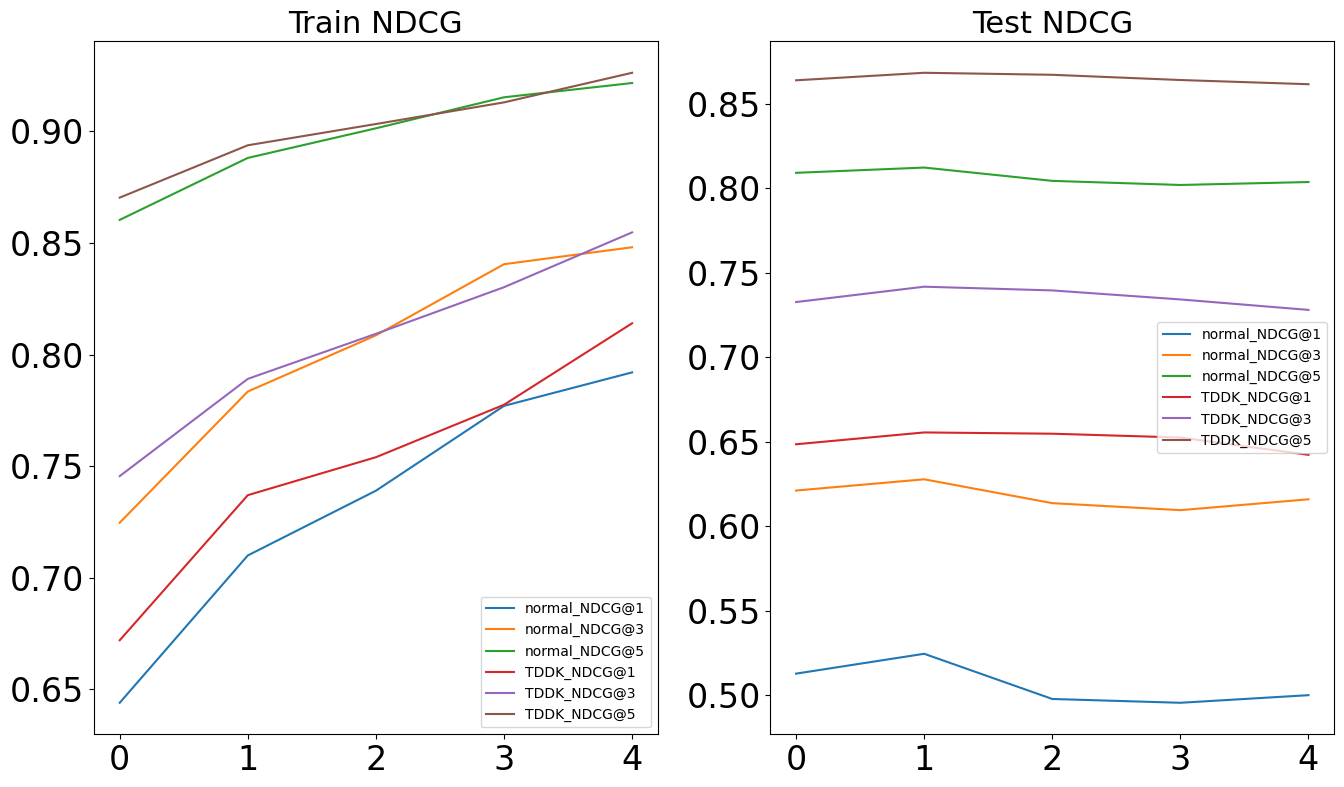

In [20]:
plt.rcParams['font.size'] = '24'

normal_losses = normal_result['loss']
normal_train_tau = normal_result['train_tau']
normal_test_tau = normal_result['test_tau']
normal_train_ndcg1 = normal_result['train_ndcg1']
normal_train_ndcg3 = normal_result['train_ndcg3']
normal_train_ndcg5 = normal_result['train_ndcg5']
normal_test_ndcg1 = normal_result['test_ndcg1']
normal_test_ndcg3 = normal_result['test_ndcg3']
normal_test_ndcg5 = normal_result['test_ndcg5']

TDDK_losses = TDDK_results['loss']
TDDK_train_tau = TDDK_results['train_tau']
TDDK_test_tau = TDDK_results['test_tau']
TDDK_train_ndcg1 = TDDK_results['train_ndcg1']
TDDK_train_ndcg3 = TDDK_results['train_ndcg3']
TDDK_train_ndcg5 = TDDK_results['train_ndcg5']
TDDK_test_ndcg1 = TDDK_results['test_ndcg1']
TDDK_test_ndcg3 = TDDK_results['test_ndcg3']
TDDK_test_ndcg5 = TDDK_results['test_ndcg5']


fig, axes = plt.subplots(ncols=2, figsize=(16,9))
axes[0].plot(normal_losses, label='normal_loss')
axes[0].set_title(f'Training loss', fontsize=22)
axes[0].plot(TDDK_losses, label='TDDK_loss')
axes[0].set_title(f'Training loss', fontsize=22)
axes[0].legend(fontsize=10)
axes[1].plot(normal_train_tau, label='normal_train_mean_kt')
axes[1].plot(normal_test_tau, label='normal_test_mean_kt')
axes[1].plot(TDDK_train_tau, label='TDDK_train_mean_kt')
axes[1].plot(TDDK_test_tau, label='TDDK_test_mean_kt')
axes[1].set_ylim(0,1)
axes[1].legend(fontsize=10)
axes[1].set_title(f'Kendall Tau', fontsize=22)
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(16,9))
axes[0].plot(normal_train_ndcg1, label='normal_NDCG@1')
axes[0].plot(normal_train_ndcg3, label='normal_NDCG@3')
axes[0].plot(normal_train_ndcg5, label='normal_NDCG@5')
axes[0].plot(TDDK_train_ndcg1, label='TDDK_NDCG@1')
axes[0].plot(TDDK_train_ndcg3, label='TDDK_NDCG@3')
axes[0].plot(TDDK_train_ndcg5, label='TDDK_NDCG@5')
axes[0].legend(fontsize=10)
axes[0].set_title(f'Train NDCG', fontsize=22)
axes[1].plot(normal_test_ndcg1, label='normal_NDCG@1')
axes[1].plot(normal_test_ndcg3, label='normal_NDCG@3')
axes[1].plot(normal_test_ndcg5, label='normal_NDCG@5')
axes[1].plot(TDDK_test_ndcg1, label='TDDK_NDCG@1')
axes[1].plot(TDDK_test_ndcg3, label='TDDK_NDCG@3')
axes[1].plot(TDDK_test_ndcg5, label='TDDK_NDCG@5')
axes[1].set_title(f'Test NDCG', fontsize=22)
axes[1].legend(fontsize=10)
plt.show()